In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# **Bike Sharing Demand** 🚴‍♂️

1. EDA: https://www.kaggle.com/code/park4264/bike-prediction-eda
- Source: https://www.kaggle.com/code/werooring/ch6-baseline/notebook


# **2. Modeling**

# 2-1. 베이스라인 모델


- 베이스라인 모델이란 뼈대가 되는 가장 기본적인 모델을 의미
- 베이스라인 모델에서 출발해 성능을 점차 향상시키는 방향으로 모델링

## 2-1-1. 전체 프로세스 설명 및 데이터 불러오기
- 데이터 불러오기 $\Rightarrow$ (기본적인) 피처 엔지니어링 $\Rightarrow$ 평가지표 계산함수 작성 $\Rightarrow$ 모델 훈련 $\Rightarrow$ 성능 검증 $\Rightarrow$ 제출

In [2]:
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 2-1-2. 피처 엔지니어링

- 보통 이 변환은 훈련데이터 테스트 데이터 공통으로 반영해야 함.
- 피처 엔지니어링 전에 두 데이터를 합쳤다가 다 끝나면 도로 나눠준다.

### 2-1-2_1. 이상치 제거

In [3]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 2-1-2_2. 데이터 합치기

- 훈련 데이터와 테스트 데이터에 같은 피처 엔지니어링을 적용하기 위해 두 데이터를 하나로 합칠 것이다.
- 판다스의 `concat()` 함수를 사용하면 축을 따라 `DataFrame`을 이어붙일 수 있다.


In [4]:
all_data_temp = pd.concat([train, test])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [5]:
all_data = pd.concat([train, test], ignore_index = True) # 원래 데이터의 인덱스를 무시하고 이어붙이기
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 2-1-2_3. 파생 피처(변수) 추가

In [6]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])

# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])

# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])

# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : 
                                             datetime.strptime(dateString,"%Y-%m-%d").weekday())

In [7]:
all_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0,2011-01-01,2011,01,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0,2011-01-01,2011,01,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0,2011-01-01,2011,01,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0,2011-01-01,2011,01,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0,2011-01-01,2011,01,04,5


- `day`, `minute`, `second` 피처는 예측에 필요가 없다.



### 2-1-2_4. 필요 없는 피처 제거

- `casual`, `registered`, `datetime`, `date`, `windspeed`, `month` 피처를 제거

In [8]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis=1)

> - **피처 선택(Feature Selection)**: 모델링 시 데이터의 특징을 잘 나타내는 주요 피처만 선택하는 작업
> - 탐색적 데이터분석, 피처 중요도(feature importance), 상관관계 매트릭스 등을 활용해 종합적으로 판단



### 2-1-2_5. 데이터 나누기

- 훈련 데이터와 테스트 데이터를 다시 나누자


In [9]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[ ~ pd.isnull(all_data['count'])] # '~': 부정을 뜻함
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

In [10]:
# 피처 엔지니어링을 모두 마친 후 훈련 데이터 구성 살펴보기
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


## 2-1-2. 평가지표 계산 함수 작성

- 본격적인 훈련에 앞서 본 경진대회 평가지표인 RMSLE를 계산하자

$$\sqrt{\dfrac{1}{N} \sum^N_{i=1} ( \log(y_i+1) - \log(\hat{y_i} + 1 )^2 }$$

In [11]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

- 실제 타깃값 `y_true`와 `y_pred`를 인수로 전달하면 RMSLE 수치를 반환하는 함수
- `convertExp`는 입력 데이터를 지수변환할지 정하는 파라미터
- `np.nan_to_num()`함수는 `NaN` 결측값을 모두 0으로 바꾸어준다


## 2-1-3. 모델 훈련

- 사이킷런이 제공하는 가장 간단한 선형 회귀 모델인 `LinearRegression`을 임포트해서 모델을 생성하자

In [12]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [13]:
# 이어서 훈련 데이터로 모델을 훈련시키자
log_y = np.log(y) #타깃값 로그 변환
linear_reg_model.fit(X_train, log_y)

LinearRegression()

## 2-1-4. 모델 성능 검정


In [14]:
preds = linear_reg_model.predict(X_train)

In [15]:
preds

array([2.19541075, 2.27905813, 2.38251905, ..., 5.6734502 , 5.82792117,
       5.82067058])

In [16]:
print (f'선형회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.3f}')

선형회귀의 RMSLE 값 : 1.020


## 2-1-5. 예측 및 결과 제출


In [17]:
linearreg_preds = linear_reg_model.predict(X_test) # 테스트 데이터로 예측
submission['count'] = np.exp(linearreg_preds) #지수 변환
submission.to_csv('submission.csv', index = False)

---
---
---


# **3. 성능 개선**
# 3-1. 성능 개선 1: <U> 릿지 회귀 모델</U>

- 사이킷런이 제공하는 모델 중 세 가지
    - 릿지 (Ridge)
    - 라쏘 (Lasso)
    - 랜덤 포레스트 (Random Forest 회귀)
    
    를 다뤄보며 가장 우수한 모델을 확인해보자
    
    
## 3-1-1. 하이퍼파라미터 최적화 (모델훈련)

- 이번에는 '모델 훈련' 단계에서 그리드 서치 기법을 사용할 것이다.
- **그리드서치(Grid Search)**: 하이퍼파라미터를 격자 처럼 촘촘하게 순회하며 최적의 하이퍼파라미터 값을 찾는 기법
- 각 하이퍼파라미터를 적용한 모델마다 교차 검증(CV)을 하며 성능을 측정하여 최종적으로 성능이 가장 좋았을 때의 하이퍼파라미터 값을 찾는다.
    - 그리드서치는 테스트 하려는 하이퍼파라미터와 값의 범위만 전달하면 알아서 모든 가능한 조합을 순회하며 교차 검증한다.
    
### 3-1-1_1. 모델 생성


In [18]:
# 가장 먼저 릿지 모델을 생성합니다.
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

### 3-1-1_2. 그리드서치 객체 생성
- 이어서 그리드서치 객체를 생성
- Note that: 그리드서치는 '하이퍼파라미터의 값'을 바꿔가며 '모델'의 성능을 교차 검증으로 '평가'해 최적의 하이퍼파라미터 값을 찾아준다고 했다.
- 즉, 그리드 서치 객체가 다음의 세 가지를 알고 있어야 한다는 뜻이다.
    1. 비교 검증해볼 하이퍼파라미터 값 목록
    2. 대상 모델
    3. 교차 검증용 평가 수단 (평가 함수)
    
    
- 하이퍼파라미터 값 목록과 평가 함수만 더 준비하면 된다.
- 릿지 모델에서 중요한 하이퍼파라미터는 `alpha`: 값이 클수록 규제 강도가 세진다


In [19]:
# 하이퍼파라미터 값 목록
ridge_params = {'max_iter':[3000],
               'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

In [20]:
# 교차 검증용 평가 함수 (RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

In [21]:
# 그리드서치 (with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator = ridge_model, #릿지 모델
                                     param_grid = ridge_params, # 파라미터 값 목록
                                     scoring = rmsle_scorer, # 평가지표
                                     cv = 5) # 교차 검증 분할 수 

- **그리드서치 객체를 생성하는 `GridSearchCV()` 함수의 주요 파라미터**
    - `estimator`: 분류 및 회귀 모델
    - `param_gird`: 딕셔너리 형태로 모델의 하이퍼파라미터명과 여러 하이퍼파라미터 값을 지정
    - `scoring`: 평가지표. 사이킷런에서 기본적인 평가지표를 문자열 형태로 제공함.
        - 예) 정확도: 'accuracy' / F1 점수: 'f1' / ROC_AUC: 'roc_auc' / 재현율: 'recall'
        - 사이킷런에서 제공하는 평가지표를 사용하지 않고 별도로 만든 평가지표를 사용해도 됨.
        - `metric.make_scorer`를 활용해 별도로 만든 평가지표를 사용할 수 있다.
    - `cv`: 교차 검증 분할 개수 (default = 5)


- 데이터가 많고 복잡한 모델을 사용하면 `GridSearchCV`의 수행 시간은 상당히 길어짐

### 3-1-1_3. 그리드서치 수행

In [22]:
# 다음은 방금 만든 그리드서치 개게를 이용하여 그리드 서치를 수행
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) #훈련 (그리드 서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

- `fit()` 메서드를 실행하면 객체 생성 시 `param_grid`에 전달된 값들을 순회하면서 교차 검증으로 평가지표 점수를 계산
    - 이때 가장 좋은 성능을 보인 값을 `best_params_` 속성에 저장
    - 최적 값으로 훈련한 모델 (최적 예측기)을 `best_estimator_` 속성에 저장합니다.

In [23]:
# 최적 하이퍼파라미터로는 어떤 값이 선정되었는지 살펴봅시다.
print('최적 하이퍼파라미터: ', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터:  {'alpha': 0.1, 'max_iter': 3000}


## 3-1-2. 성능 검증

- 최종 예측은 그리드서치 객체의 `best_estimator_` 속성에 저장된 모델로 수행하면 됩니다.

In [24]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

In [25]:
# 평가
print(f'릿지 회귀 RMSLE 값: {rmsle(log_y, preds, True):.3f}')

릿지 회귀 RMSLE 값: 1.020


- 😮 선형 회귀 모델의 결과와 크게 다르지 않다..

# 3-2. 성능 개선 2: <U>라쏘 회귀 모델</U>

## 3-2-1. 하이퍼파라미터 최적화 (모델 훈련)

- 릿지 회귀와 마찬가지로 `alpha`는 규제 강도를 조정하는 파라미터

In [26]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


## 3-2-2. 성능 검증

In [27]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.3f}')

라쏘 회귀 RMSLE 값 : 1.020


# 3-2. 성능 개선 3: <U>랜덤 포레스트 회귀 모델</U>

- 랜덤 포레스트 회귀는 간단히 생각하면 훈련 데이터를 랜덤하게 샘플링한 모델 n개를 각가 훈련하여 셜과를 평균하는 방법

## 3-2-1. 하이퍼파라미터 최적화 (모델 훈련)

- 랜덤 포레스트 회귀 모델로 그리드서치를 수행하고 최적 하이퍼파라미터 값까지 출력해보자

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
# 모델 생성
randomforest_model = RandomForestRegressor()

# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]} # 랜덤 시드값 / 결정 트리 개수
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터:', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터: {'n_estimators': 140, 'random_state': 42}


## 3-2-2. 모델 성능 검증

In [30]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


- 💡랜덤 포레스트 회귀 모델을 사용하니 RMSLE 값이 큰 폭으로 개선되었다.






## 3-2-3. 예측 및 결과 제출
- 먼저 훈련 데이터 타깃값과 테스트 데이터 타깃 예측값의 분포를 살펴보자


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

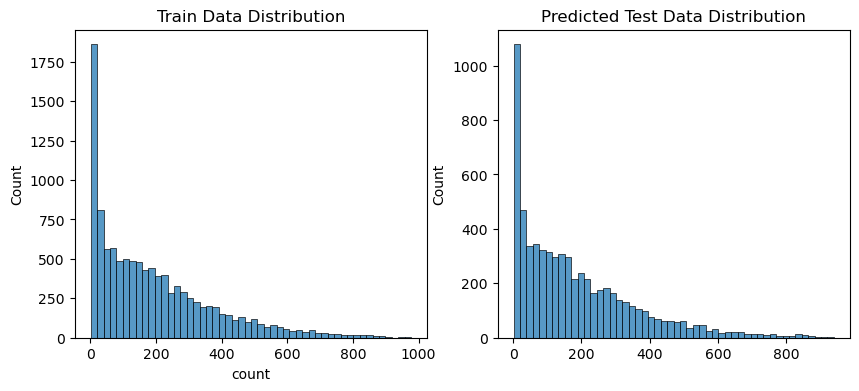

In [32]:
randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols = 2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins = 50, ax = axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [33]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)